The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Maximum Likelihood
:label:`sec_maximum_likelihood`

One of the most commonly encountered way of thinking in machine learning is the maximum likelihood point of view.  This is the concept that when working with a probabilistic model with unknown parameters, the parameters which make the data have the highest probability are the most likely ones.

## The Maximum Likelihood Principle

This has a Bayesian interpretation which can be helpful to think about.  Suppose that we have a model with parameters $\boldsymbol{\theta}$ and a collection of data examples $X$.  For concreteness, we can imagine that $\boldsymbol{\theta}$ is a single value representing the probability that a coin comes up heads when flipped, and $X$ is a sequence of independent coin flips.  We will look at this example in depth later.

If we want to find the most likely value for the parameters of our model, that means we want to find

$$\mathop{\mathrm{argmax}} P(\boldsymbol{\theta}\mid X).$$
:eqlabel:`eq_max_like`

By Bayes' rule, this is the same thing as

$$
\mathop{\mathrm{argmax}} \frac{P(X \mid \boldsymbol{\theta})P(\boldsymbol{\theta})}{P(X)}.
$$

The expression $P(X)$, a parameter agnostic probability of generating the data, does not depend on $\boldsymbol{\theta}$ at all, and so can be dropped without changing the best choice of $\boldsymbol{\theta}$.  Similarly, we may now posit that we have no prior assumption on which set of parameters are better than any others, so we may declare that $P(\boldsymbol{\theta})$ does not depend on theta either!  This, for instance, makes sense in our coin flipping example where the probability it comes up heads could be any value in $[0,1]$ without any prior belief it is fair or not (often referred to as an *uninformative prior*).  Thus we see that our application of Bayes' rule shows that our best choice of $\boldsymbol{\theta}$ is the maximum likelihood estimate for $\boldsymbol{\theta}$:

$$
\hat{\boldsymbol{\theta}} = \mathop{\mathrm{argmax}} _ {\boldsymbol{\theta}} P(X \mid \boldsymbol{\theta}).
$$

As a matter of common terminology, the probability of the data given the parameters ($P(X \mid \boldsymbol{\theta})$) is referred to as the *likelihood*.

### A Concrete Example

Let's see how this works in a concrete example.  Suppose that we have a single parameter $\theta$ representing the probability that a coin flip is heads.  Then the probability of getting a tails is $1-\theta$, and so if our observed data $X$ is a sequence with $n_H$ heads and $n_T$ tails, we can use the fact that independent probabilities multiply to see that 

$$
P(X \mid \theta) = \theta^{n_H}(1-\theta)^{n_T}.
$$

If we flip $13$ coins and get the sequence "HHHTHTTHHHHHT", which has $n_H = 9$ and $n_T = 4$, we see that this is

$$
P(X \mid \theta) = \theta^9(1-\theta)^4.
$$

One nice thing about this example will be that we know the answer going in.  Indeed, if we said verbally, "I flipped 13 coins, and 9 came up heads, what is our best guess for the probability that the coin comes us heads?, " everyone would correctly guess $9/13$.  What this maximum likelihood method will give us is a way to get that number from first principals in a way that will generalize to vastly more complex situations.

For our example, the plot of $P(X \mid \theta)$ is as follows:


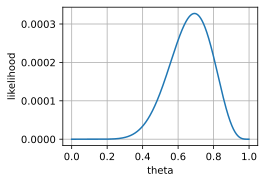

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

theta = torch.arange(0, 1, 0.001)
p = theta**9 * (1 - theta)**4.

d2l.plot(theta, p, 'theta', 'likelihood')

This has its maximum value somewhere near our expected $9/13 \approx 0.7\ldots$.  To see if it is exactly there, we can turn to calculus.  Notice that at the maximum, the gradient of the function is flat.  Thus, we could find the maximum likelihood estimate :eqref:`eq_max_like` by finding the values of $\theta$ where the derivative is zero, and finding the one that gives the highest probability.  We compute:

$$
\begin{aligned}
0 & = \frac{d}{d\theta} P(X \mid \theta) \\
& = \frac{d}{d\theta} \theta^9(1-\theta)^4 \\
& = 9\theta^8(1-\theta)^4 - 4\theta^9(1-\theta)^3 \\
& = \theta^8(1-\theta)^3(9-13\theta).
\end{aligned}
$$

This has three solutions: $0$, $1$ and $9/13$.  The first two are clearly minima, not maxima as they assign probability $0$ to our sequence.  The final value does *not* assign zero probability to our sequence, and thus must be the maximum likelihood estimate $\hat \theta = 9/13$.

## Numerical Optimization and the Negative Log-Likelihood

The previous example is nice, but what if we have billions of parameters and data examples?

First, notice that if we make the assumption that all the data examples are independent, we can no longer practically consider the likelihood itself as it is a product of many probabilities.  Indeed, each probability is in $[0,1]$, say typically of value about $1/2$, and the product of $(1/2)^{1000000000}$ is far below machine precision.  We cannot work with that directly.  

However, recall that the logarithm turns products to sums, in which case 

$$
\log((1/2)^{1000000000}) = 1000000000\cdot\log(1/2) \approx -301029995.6\ldots
$$

This number fits perfectly within even a single precision $32$-bit float.  Thus, we should consider the *log-likelihood*, which is

$$
\log(P(X \mid \boldsymbol{\theta})).
$$

Since the function $x \mapsto \log(x)$ is increasing, maximizing the likelihood is the same thing as maximizing the log-likelihood.  Indeed in :numref:`sec_naive_bayes` we will see this reasoning applied when working with the specific example of the naive Bayes classifier.

We often work with loss functions, where we wish to minimize the loss.  We may turn maximum likelihood into the minimization of a loss by taking $-\log(P(X \mid \boldsymbol{\theta}))$, which is the *negative log-likelihood*.

To illustrate this, consider the coin flipping problem from before, and pretend that we do not know the closed form solution.  We may compute that

$$
-\log(P(X \mid \boldsymbol{\theta})) = -\log(\theta^{n_H}(1-\theta)^{n_T}) = -(n_H\log(\theta) + n_T\log(1-\theta)).
$$

This can be written into code, and freely optimized even for billions of coin flips.


In [2]:
# Set up our data
n_H = 8675309
n_T = 256245

# Initialize our paramteres
theta = torch.tensor(0.5, requires_grad=True)

# Perform gradient descent
lr = 1e-9
for iter in range(100):
    loss = -(n_H * torch.log(theta) + n_T * torch.log(1 - theta))
    loss.backward()
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.grad.zero_()

# Check output
theta, n_H / (n_H + n_T)

(tensor(0.9713, requires_grad=True), 0.9713101437890875)

Numerical convenience is not the only reason why people like to use negative log-likelihoods. There are several other reasons why it is preferable.



The second reason we consider the log-likelihood is the simplified application of calculus rules. As discussed above, due to independence assumptions, most probabilities we encounter in machine learning are products of individual probabilities.

$$
P(X\mid\boldsymbol{\theta}) = p(x_1\mid\boldsymbol{\theta})\cdot p(x_2\mid\boldsymbol{\theta})\cdots p(x_n\mid\boldsymbol{\theta}).
$$

This means that if we directly apply the product rule to compute a derivative we get

$$
\begin{aligned}
\frac{\partial}{\partial \boldsymbol{\theta}} P(X\mid\boldsymbol{\theta}) & = \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_1\mid\boldsymbol{\theta})\right)\cdot P(x_2\mid\boldsymbol{\theta})\cdots P(x_n\mid\boldsymbol{\theta}) \\
& \quad + P(x_1\mid\boldsymbol{\theta})\cdot \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_2\mid\boldsymbol{\theta})\right)\cdots P(x_n\mid\boldsymbol{\theta}) \\
& \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \vdots \\
& \quad + P(x_1\mid\boldsymbol{\theta})\cdot P(x_2\mid\boldsymbol{\theta}) \cdots \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_n\mid\boldsymbol{\theta})\right).
\end{aligned}
$$

This requires $n(n-1)$ multiplications, along with $(n-1)$ additions, so it is proportional to quadratic time in the inputs!  Sufficient cleverness in grouping terms will reduce this to linear time, but it requires some thought.  For the negative log-likelihood we have instead

$$
-\log\left(P(X\mid\boldsymbol{\theta})\right) = -\log(P(x_1\mid\boldsymbol{\theta})) - \log(P(x_2\mid\boldsymbol{\theta})) \cdots - \log(P(x_n\mid\boldsymbol{\theta})),
$$

which then gives

$$
- \frac{\partial}{\partial \boldsymbol{\theta}} \log\left(P(X\mid\boldsymbol{\theta})\right) = \frac{1}{P(x_1\mid\boldsymbol{\theta})}\left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_1\mid\boldsymbol{\theta})\right) + \cdots + \frac{1}{P(x_n\mid\boldsymbol{\theta})}\left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_n\mid\boldsymbol{\theta})\right).
$$

This requires only $n$ divides and $n-1$ sums, and thus is linear time in the inputs.

The third and final reason to consider the negative log-likelihood is the relationship to information theory, which we will discuss in detail in :numref:`sec_information_theory`.  This is a rigorous mathematical theory which gives a way to measure the degree of information or randomness in a random variable.  The key object of study in that field is the entropy which is 

$$
H(p) = -\sum_{i} p_i \log_2(p_i),
$$

which measures the randomness of a source. Notice that this is nothing more than the average $-\log$ probability, and thus if we take our negative log-likelihood and divide by the number of data examples, we get a relative of entropy known as cross-entropy.  This theoretical interpretation alone would be sufficiently compelling to motivate reporting the average negative log-likelihood over the dataset as a way of measuring model performance.

## Maximum Likelihood for Continuous Variables

Everything that we have done so far assumes we are working with discrete random variables, but what if we want to work with continuous ones?

The short summary is that nothing at all changes, except we replace all the instances of the probability with the probability density.  Recalling that we write densities with lower case $p$, this means that for example we now say

$$
-\log\left(p(X\mid\boldsymbol{\theta})\right) = -\log(p(x_1\mid\boldsymbol{\theta})) - \log(p(x_2\mid\boldsymbol{\theta})) \cdots - \log(p(x_n\mid\boldsymbol{\theta})) = -\sum_i \log(p(x_i \mid \theta)).
$$

The question becomes, "Why is this OK?"  After all, the reason we introduced densities was because probabilities of getting specific outcomes themselves was zero, and thus is not the probability of generating our data for any set of parameters zero?

Indeed, this is the case, and understanding why we can shift to densities is an exercise in tracing what happens to the epsilons.

Let's first re-define our goal.  Suppose that for continuous random variables we no longer want to compute the probability of getting exactly the right value, but instead matching to within some range $\epsilon$.  For simplicity, we assume our data is repeated observations $x_1, \ldots, x_N$ of identically distributed random variables $X_1, \ldots, X_N$.  As we have seen previously, this can be written as

$$
\begin{aligned}
&P(X_1 \in [x_1, x_1+\epsilon], X_2 \in [x_2, x_2+\epsilon], \ldots, X_N \in [x_N, x_N+\epsilon]\mid\boldsymbol{\theta}) \\
\approx &\epsilon^Np(x_1\mid\boldsymbol{\theta})\cdot p(x_2\mid\boldsymbol{\theta}) \cdots p(x_n\mid\boldsymbol{\theta}).
\end{aligned}
$$

Thus, if we take negative logarithms of this we obtain

$$
\begin{aligned}
&-\log(P(X_1 \in [x_1, x_1+\epsilon], X_2 \in [x_2, x_2+\epsilon], \ldots, X_N \in [x_N, x_N+\epsilon]\mid\boldsymbol{\theta})) \\
\approx & -N\log(\epsilon) - \sum_{i} \log(p(x_i\mid\boldsymbol{\theta})).
\end{aligned}
$$

If we examine this expression, the only place that the $\epsilon$ occurs is in the additive constant $-N\log(\epsilon)$.  This does not depend on the parameters $\boldsymbol{\theta}$ at all, so the optimal choice of $\boldsymbol{\theta}$ does not depend on our choice of $\epsilon$!  If we demand four digits or four-hundred, the best choice of $\boldsymbol{\theta}$ remains the same, thus we may freely drop the epsilon to see that what we want to optimize is

$$
- \sum_{i} \log(p(x_i\mid\boldsymbol{\theta})).
$$

Thus, we see that the maximum likelihood point of view can operate with continuous random variables as easily as with discrete ones by replacing the probabilities with probability densities.

## Summary
* The maximum likelihood principle tells us that the best fit model for a given dataset is the one that generates the data with the highest probability.
* Often people work with the negative log-likelihood instead for a variety of reasons: numerical stability, conversion of products to sums (and the resulting simplification of gradient computations), and theoretical ties to information theory.
* While simplest to motivate in the discrete setting, it may be freely generalized to the continuous setting as well by maximizing the probability density assigned to the datapoints.

## Exercises
1. Suppose that you know that a non-negative random variable has density $\alpha e^{-\alpha x}$ for some value $\alpha>0$.  You obtain a single observation from the random variable which is the number $3$.  What is the maximum likelihood estimate for $\alpha$?
2. Suppose that you have a dataset of samples $\{x_i\}_{i=1}^N$ drawn from a Gaussian with unknown mean, but variance $1$.  What is the maximum likelihood estimate for the mean?


[Discussions](https://discuss.d2l.ai/t/1096)
